# CAM and Salience Visualization of model

Use this with the data folder to get visualization goodies

In [4]:
from vis.utils import utils
from keras import activations
from keras.models import load_model

model = load_model('epochs_200_datav2_densenet_regularize_0.01_2018-09-08_20-32-08_weights.chkpt.hdf5')

/Users/nathaniel/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/nathaniel/miniconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Isolation of branch

Now we selectively isolate the model for stenosis

In [6]:
from keras.models import Model

sten_model = Model(inputs=[model.inputs[0]], output=[model.outputs[0]])
sten_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50176)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50176)             200704    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                3211328   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

/Users/nathaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  import sys


In [19]:
layer_idx = utils.find_layer_idx(sten_model, 'densenet121')

# Swap softmax with linear
sten_model.layers[layer_idx].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [7]:
anatomy_model = Model(inputs=[model.inputs[0]], output=[model.outputs[1]])
anatomy_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50176)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50176)             200704    
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1003540   
_________________________________________________________________
anatomy_output (Dense)       (None, 4)                 84        
Total para

/Users/nathaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  """Entry point for launching an IPython kernel.


## Modify stenosis

In [8]:
layer_idx = utils.find_layer_idx(sten_model, 'stenosis_output')

# Swap softmax with linear
sten_model.layers[layer_idx].activation = activations.linear
sten_model = utils.apply_modifications(sten_model)

/Users/nathaniel/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


/Users/nathaniel/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/nathaniel/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


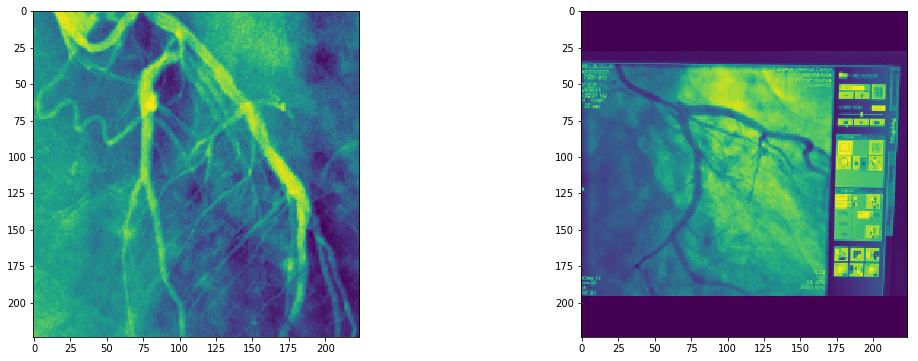

In [10]:
from vis.utils import utils
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

img1 = utils.load_img('../data/dev/00_BK113-invert-ptcanvas-sqtrim-resizeBW224.jpg', target_size=(224, 224))
img2 = utils.load_img('../data/dev/00_BK134-ptcanvas-sqtrim-resizeBW224.jpg', target_size=(224, 224))

f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x14bbe8a58>>
Traceback (most recent call last):
  File "/Users/nathaniel/miniconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1398, in __del__
    self._session._session, self._handle, status)
  File "/Users/nathaniel/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 519, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 140526920637600


InvalidArgumentError: main_input_1:0 is both fed and fetched.

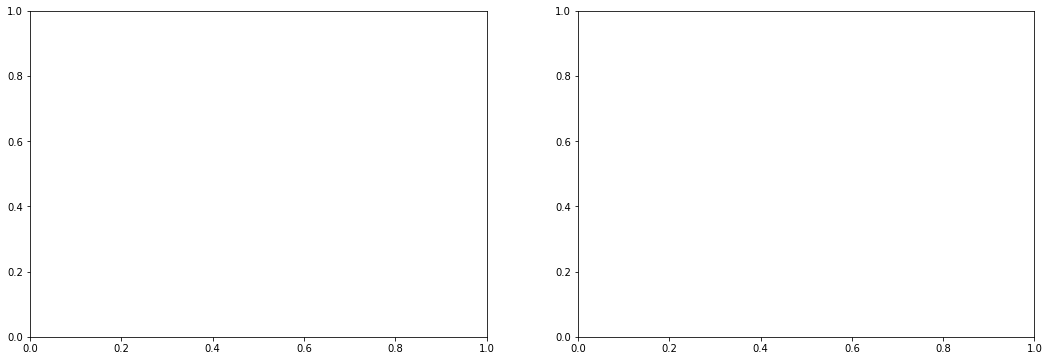

In [16]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(sten_model, 'stenosis_output')

f, ax = plt.subplots(1, 2)
for i, img in enumerate([img1, img2]):    
    grads = visualize_saliency(sten_model, layer_idx, filter_indices=None, seed_input=img)
    
    # visualize grads as heatmap
    ax[i].imshow(grads, cmap='jet')

AttributeError: Layer densenet121 has multiple inbound nodes, hence the notion of "layer input" is ill-defined. Use `get_input_at(node_index)` instead.

<Figure size 1296x432 with 0 Axes>

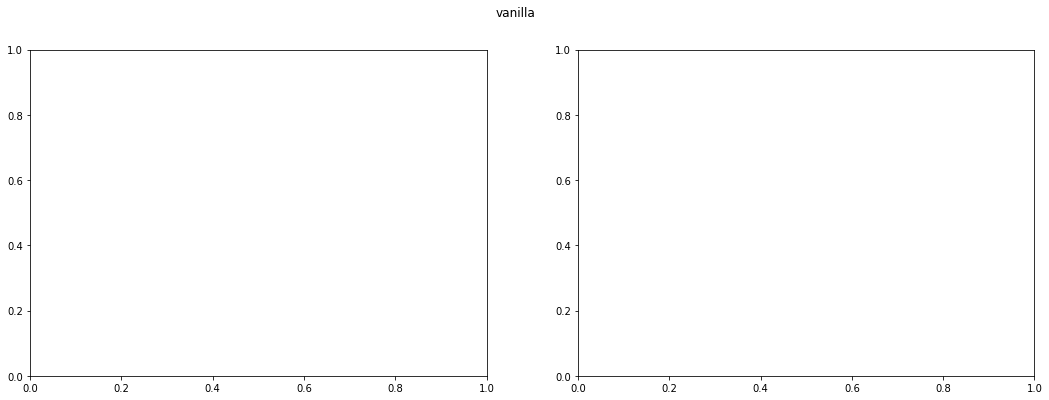

In [26]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam

dense_idx = utils.find_layer_idx(sten_model, 'densenet121')
layer_idx = utils.find_layer_idx(sten_model, 'stenosis_output')

for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2]):    
        grads = visualize_cam(sten_model.layers[dense_idx], -1, filter_indices=None, 
                              seed_input=img, backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ax[i].imshow(overlay(jet_heatmap, img))